# TODO
- fix so that model uses q_true and s_true

In [1]:
%load_ext autoreload
%autoreload 2

#https://mc-stan.org/docs/2_18/stan-users-guide/bayesian-measurement-error-model.html

In [2]:
# add noise to prediction

In [3]:
#from mdm.dataset import Standardization, LogTransform
RANDOM_SEED=1985

In [4]:
import pandas as pd
import pymc3 as pm

import arviz as az
import matplotlib.pyplot as plt
import numpy as np

import theano.tensor as tt

In [5]:
#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/green_channel.csv")
df = pd.read_csv("../data/co_channel.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

In [6]:
def tt_standardize(x, x_o=None):
    if x_o is None:
        x_o = x
        
    x_std = (x - tt.mean(x_o)) / tt.std(x_o)
    return x_std


def tt_unstandardize(x_std, x_o):
    #import pdb; pdb.set_trace()    
    x = x_std * tt.std(x_o) + tt.mean(x_o)
    return x

def unstandardize(x_std, x_o):
    #import pdb; pdb.set_trace()    
    x = x_std * np.std(x_o) + np.mean(x_o)
    return x




def tt_log_standardize(x, x_o=None):
    if x_o is None:
        x_o = x
    
    log_x = tt.log(x)
    log_x_o = tt.log(x_o)
    x_std = (log_x - tt.mean(log_x_o)) / (tt.std(log_x_o))
    return x_std
    

def tt_log_unstandardize(x_std, x_o):

    log_x_o = tt.log(x_o) #observed
    log_x = x_std * tt.std(log_x_o) + tt.mean(log_x_o)
    return tt.exp(log_x)
    
def tt_standardize_stage(x, offset, x_o=None):
    if x_o is None:
        x_o = x
    
    log_x = tt.log(x) - offset
    log_x_o = tt.log(x_o) - offset
    x_std = (log_x - tt.mean(log_x_o)) / (tt.std(log_x_o))
    return x_std

def tt_unstandardize_stage(x_std, offset, x_o):

    log_x_o = tt.log(x_o) - offset #observed
    log_x = x_std * tt.std(log_x_o) + tt.mean(log_x_o)
    return tt.exp(log_x + offset)

# plotting?
def predictive_plot(ppc, q_obs, s_obs, offset=False, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    
    s_obs.min()
    s_min = np.floor(s_obs.min())
    s_max = np.ceil(s_obs.max())
    s_sim = np.linspace(s_min, s_max)
    
    if offset:
        o = ppc['offset']
    else:
        o = 0
      
    predictor_scaled = tt_log_standardize(s_sim-o, s_obs-o).eval()
    q_pred = tt_log_unstandardize(ppc['q_log'], df['q']).eval()
    
    log_mu_ppq = (ppc["a"] + ppc["b"] * predictor_scaled[:, None]).T
    
    log_pred_ppq = (ppc["a"] + ppc["b"] * predictor_scaled[:, None] + ppc['sigma'] * pm.Normal.dist(0,1).random(size=2000)).T
    
    mu_ppq = tt_log_unstandardize(log_mu_ppq, q_obs).eval()
    pred_ppq = tt_log_unstandardize(log_pred_ppq, q_obs).eval()
    
    
    
    #plt.plot(df['stage'], df['q'], "o", ms=4, alpha=0.4, label="Data", color='k')
    
    ax.errorbar(df['stage'],  df['q'], yerr=1.96*df['q_sigma'], fmt='.k');
    
    ax.plot(s_sim, mu_ppq.mean(0), label="Mean outcome", alpha=0.6)
    
    
    az.plot_hdi(
        s_sim,
        pred_ppq,
        ax=ax,
        fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Predictive 94% HPD"},
    )
    
    
    ax.set_xlabel("Stage (feet)")
    ax.set_ylabel("Discharge (ft3/s)")
    
    ax.legend(ncol=2, fontsize=10)

In [7]:
#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/green_channel.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

q_obs = df['q'].values
s_obs = df['stage'].values

q_sigma = df['q_sigma'].values
s_sigma = 0.02
#s_sigma = 0.5

n = df['q'].shape[0]

In [32]:
lg_q_s

0.7832034988647618

In [8]:
lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    #a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f)
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_u/2)
    b = pm.Normal("b", mu=slope_u, sigma=slope_u)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    offset = pm.Uniform('offset', 0, 2)
    #offset = pm.HalfNormal('offset', sigma=2)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    #q_std = tt_log_standardize(q_true, x_o=q_obs)
    #s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    #mu = a + b * lg_s #worked without offset
    mu = a + b * tt.log(s_true - offset)
    y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_true)
    #y = pm.Normal("y",
    #             mu=mu,
    #             sigma=sigma,
    #             observed=lg_q)

In [9]:
with error_model:
    error_trace = pm.sample(500, tune=2000, return_inferencedata=False, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, sigma, b, a]


Sampling 4 chains for 2_000 tune and 500 draw iterations (8_000 + 2_000 draws total) took 181 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [11]:
with error_model:
    error_trace = pm.sample(500, tune=2000, return_inferencedata=False, target_accept=0.95)
    ppc = pm.sample_posterior_predictive(
        error_trace, var_names=["a", "b", "sigma","offset", "q"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, sigma, b, a]


Sampling 4 chains for 2_000 tune and 500 draw iterations (8_000 + 2_000 draws total) took 185 seconds.
The number of effective samples is smaller than 25% for some parameters.


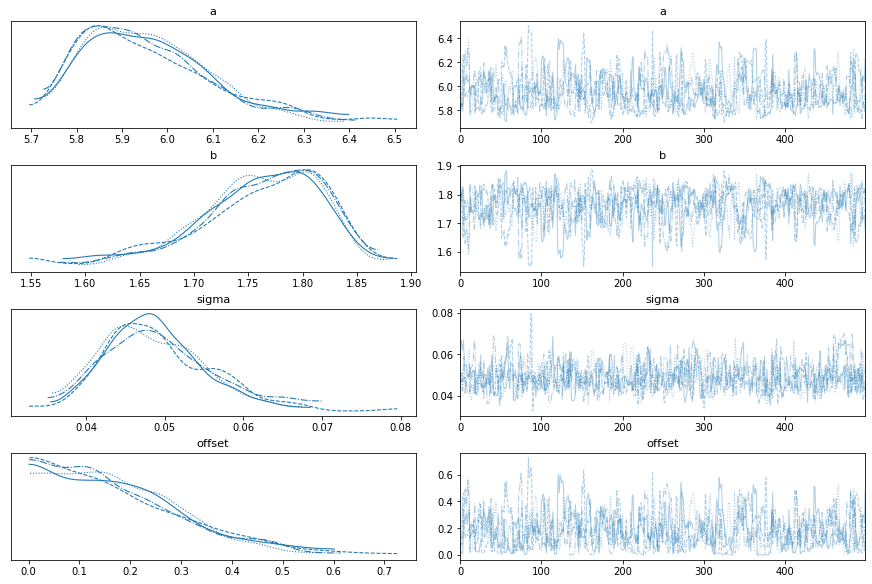

In [10]:
with error_model:
    az.plot_trace(error_trace);

In [9]:
error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    offset = pm.Uniform('offset', 0, 4)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    q_std = tt_log_standardize(q_true, x_o=q_obs)
    s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)
    

In [10]:
with error_model:
    error_trace = pm.sample(500, return_inferencedata=False, target_accept=0.95)
    ppc = pm.sample_posterior_predictive(
        error_trace, var_names=["a", "b", "sigma","offset", "q_log"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

In [24]:
error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    offset = pm.Uniform('offset', 0, 4)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    q_std = tt_log_standardize(q_true, x_o=q_obs)
    s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)
    
    

In [40]:
error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    offset = pm.Uniform('offset', 0, 4)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    q_std = tt_log_standardize(q_true, x_o=q_obs)
    s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)
    
    

In [41]:
with error_model:
    error_trace = pm.sample(500, return_inferencedata=False, target_accept=0.95)
    ppc = pm.sample_posterior_predictive(
        error_trace, var_names=["a", "b", "sigma","offset", "q_log"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 46 seconds.


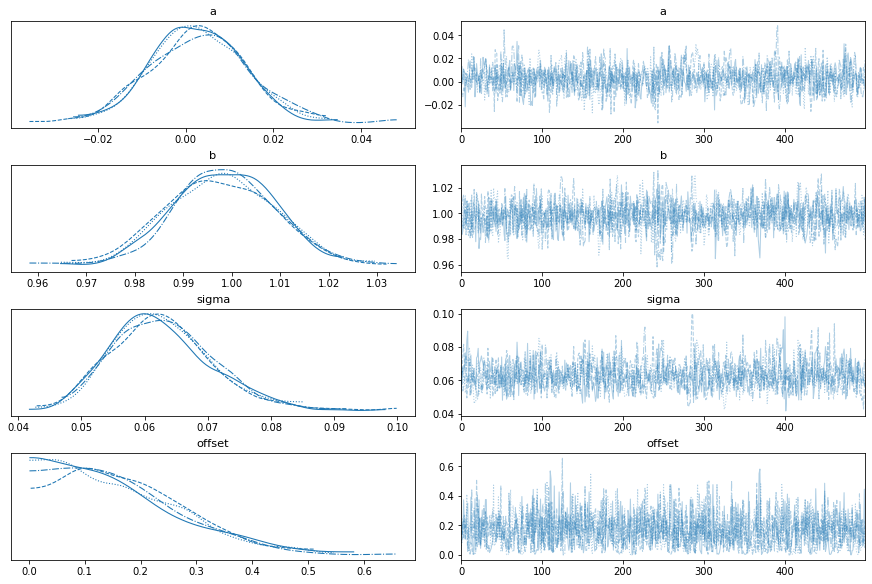

In [42]:
with error_model:
    az.plot_trace(error_trace);

C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


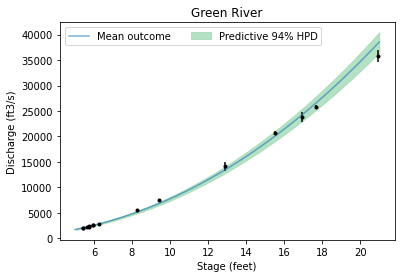

In [133]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, ax=ax)
ax.set_title("Green River")
fig.savefig("../figures/green_channel.pdf")

In [29]:
output = pd.DataFrame() 

In [30]:
#site = 'Green River'
#a = ppc['a'].mean()
#b = ppc['b'].mean()
#sigma = ppc['sigma'].mean()
#gerr = np.exp(sigma*1.96)
#
#results = pd.Series({'a':a,'b':b,'gerr':gerr}, name='Green River')
#output = output.append(results)

In [31]:
site = 'Green River'

a= ppc['a'].mean()
sigma = ppc['sigma'].mean() 
b= ppc['b'].mean() 
sigma = ppc['sigma'].mean()
offset = ppc['offset'].mean()

log_q = np.log(q_obs)
log_s = np.log(s_obs-offset)
a_s = log_q.std()*(a-b*log_s.mean()/log_s.std())+log_q.mean()
b_s = b*log_q.std()/log_s.std()
sigma_s = log_q.std()*sigma
gerr95 = np.exp(sigma_s)**1.96

results = pd.Series({'a':a_s,'b':b_s, 'offset':offset, 'sigma':sigma_s, 'gerr95':gerr95}, name='Green River')
output = output.append(results)

In [32]:
output

,a,b,gerr95,offset,sigma
Green River,5.882225,1.80143,1.092895,0.133532,0.045322


In [86]:
#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/co_channel.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

q_obs = df['q'].values
s_obs = df['stage'].values

q_sigma = df['q_sigma'].values
s_sigma = 0.02
#s_sigma = 0.5

n = df['q'].shape[0]

In [87]:
s_obs.min()

5.43

In [34]:
error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    offset = pm.Uniform('offset', 0, 4)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    q_std = tt_log_standardize(q_true, x_o=q_obs)
    s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)
    
    

In [39]:
with error_model:
    error_trace = pm.sample(500, return_inferencedata=False, target_accept=0.95)
    ppc = pm.sample_posterior_predictive(
        error_trace, var_names=["a", "b", "sigma","offset", "q_log"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 44 seconds.


C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


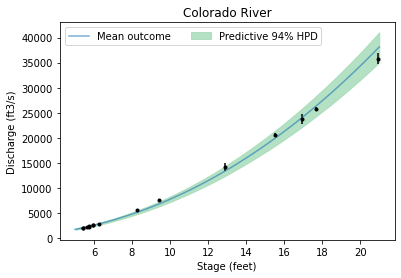

In [40]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, ax=ax)
ax.set_title("Colorado River")
fig.savefig("../figures/co_channel.pdf")

In [41]:
site = 'Colorado River'

a= ppc['a'].mean()
sigma = ppc['sigma'].mean() 
b= ppc['b'].mean() 
sigma = ppc['sigma'].mean()
offset = ppc['offset'].mean()

log_q = np.log(q_obs)
log_s = np.log(s_obs-offset)
a_s = log_q.std()*(a-b*log_s.mean()/log_s.std())+log_q.mean()
b_s = b*log_q.std()/log_s.std()
sigma_s = log_q.std()*sigma
gerr95 = np.exp(sigma_s)**1.96

results = pd.Series({'a':a_s,'b':b_s, 'offset':offset, 'sigma':sigma_s, 'gerr95':gerr95}, name='Colorado River')
output = output.append(results)

In [42]:

#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/chalk_artificial.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

q_obs = df['q'].values
s_obs = df['stage'].values

q_sigma = df['q_sigma'].values
s_sigma = 0.02
#s_sigma = 0.5

n = df['q'].shape[0]

In [43]:
error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    offset = pm.Uniform('offset', 0, 4)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    q_std = tt_log_standardize(q_true, x_o=q_obs)
    s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)
    

In [44]:
with error_model:
    error_trace = pm.sample(500, return_inferencedata=False, target_accept=0.95)
    ppc = pm.sample_posterior_predictive(
        error_trace, var_names=["a", "b", "sigma","offset", "q_log"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 47 seconds.


C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


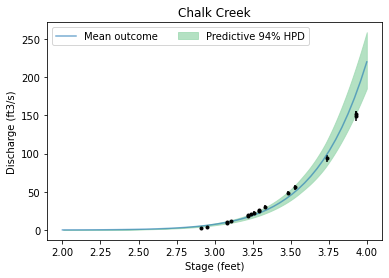

In [45]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, ax=ax)
ax.set_title("Chalk Creek")
fig.savefig("../figures/chalk_artificial.pdf")

In [46]:
site = 'Chalk Creek'

a= ppc['a'].mean()
sigma = ppc['sigma'].mean() 
b= ppc['b'].mean() 
sigma = ppc['sigma'].mean()
offset = ppc['offset'].mean()

log_q = np.log(q_obs)
log_s = np.log(s_obs-offset)
a_s = log_q.std()*(a-b*log_s.mean()/log_s.std())+log_q.mean()
b_s = b*log_q.std()/log_s.std()
sigma_s = log_q.std()*sigma
gerr95 = np.exp(sigma_s)**1.96

results = pd.Series({'a':a_s,'b':b_s, 'offset':offset, 'sigma':sigma_s, 'gerr95':gerr95}, name='Chalk Creek')
output = output.append(results)

In [47]:

#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/provo_natural.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

q_obs = df['q'].values
s_obs = df['stage'].values

q_sigma = df['q_sigma'].values
q_sigma = q_sigma
s_sigma = 0.02
#s_sigma = 0.5

n = df['q'].shape[0]

In [48]:
error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    offset = pm.Uniform('offset', 0, 4)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    q_std = tt_log_standardize(q_true, x_o=q_obs)
    s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)
    
    

In [49]:
with error_model:
    error_trace = pm.sample(500, return_inferencedata=False, target_accept=0.95)
    ppc = pm.sample_posterior_predictive(
        error_trace, var_names=["a", "b", "sigma","offset", "q_log"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 55 seconds.


C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


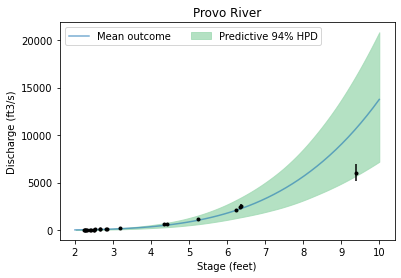

In [50]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, offset=True, ax=ax)
ax.set_title("Provo River")
fig.savefig("../figures/provo_natural.pdf")

ValueError: operands could not be broadcast together with shapes (50,) (2000,) 

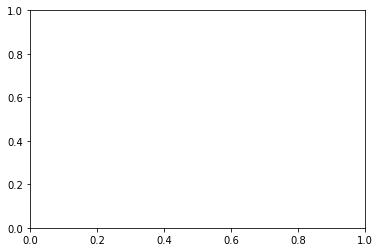

In [69]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, offset=True, ax=ax)
ax.set_title("Provo River")
fig.savefig("../figures/provo_natural.pdf")

In [71]:
ppc['offset'].shape

(2000,)

In [52]:
output.to_csv('../simple_offset_rating.csv')


In [55]:
output[['a','b','offset','sigma','gerr95']].to_csv('../simple_offset_rating.csv')

# Scratch

In [118]:
w = pm.floatX([0.2, 0.8])
mu = pm.floatX([-0.3, 0.5])
sd = pm.floatX([0.1, 0.1])

In [120]:
import theano

In [121]:
with pm.Model() as model:

    x = pm.NormalMixture("x", w=w, mu=mu, sigma=sd, dtype=theano.config.floatX)
    x2 = x ** 2
    sin_x = pm.math.sin(x)


You can find the C code in this temporary file: C:\Users\thodson\AppData\Local\Temp\1\theano_compilation_error_hc0pu8ol


Exception: ('Compilation failed (return status=1): C:\\Users\\thodson\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.18363-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.10-64\\tmpbkskkh3g\\mod.cpp:312:19: internal compiler error: Segmentation fault\r.                    V1_i = (V3_i > 0) ? 1. : ((V3_i < 0) ? -1. : (isnan(V3_i) ? NAN : 0.));\r.                    ^\r. libbacktrace could not find executable to open\r. Please submit a full bug report,\r. with preprocessed source if appropriate.\r. See <https://sourceforge.net/projects/msys2> for instructions.\r. ', 'FunctionGraph(Elemwise{sgn,no_inplace}(<TensorType(float64, scalar)>))')

In [150]:
with model:
    mean_field = pm.fit(method="advi")

TypeError: Model does not have FreeRVs

In [ ]:
w = pm.floatX([0.2, 0.8])
mu = pm.floatX([-0.3, 0.5])
sd = pm.floatX([0.1, 0.1])

In [151]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano

np.random.seed(42)
pm.set_tt_rng(42)

In [152]:
w = pm.floatX([0.2, 0.8])
mu = pm.floatX([-0.3, 0.5])
sd = pm.floatX([0.1, 0.1])

with pm.Model() as model:
    x = pm.NormalMixture("x", w=w, mu=mu, sigma=sd, dtype=theano.config.floatX)
    x2 = x ** 2
    sin_x = pm.math.sin(x)


You can find the C code in this temporary file: C:\Users\thodson\AppData\Local\Temp\1\theano_compilation_error_iypti5r5


Exception: ('Compilation failed (return status=1): C:\\Users\\thodson\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.18363-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.10-64\\tmpio9fsvop\\mod.cpp:312:19: internal compiler error: Segmentation fault\r.                    V1_i = (V3_i > 0) ? 1. : ((V3_i < 0) ? -1. : (isnan(V3_i) ? NAN : 0.));\r.                    ^\r. libbacktrace could not find executable to open\r. Please submit a full bug report,\r. with preprocessed source if appropriate.\r. See <https://sourceforge.net/projects/msys2> for instructions.\r. ', 'FunctionGraph(Elemwise{sgn,no_inplace}(<TensorType(float64, scalar)>))')

In [ ]:
with model:
    pm.Deterministic("x2", x2)
    pm.Deterministic("sin_x", sin_x)

In [ ]:
with pm.Model() as model:

    x = pm.NormalMixture("x", w=w, mu=mu, sigma=sd, dtype=theano.config.floatX)
    x2 = x ** 2
    sin_x = pm.math.sin(x)

In [ ]:
pm.plot_posterior(mean_field.sample(1000), color="LightSeaGreen");